Final stage. Here we take the maps made and calculate the total amount of volatile storage. In the manuscript we compare two different methods of masking the data. Here I just show one (NN and COB masked).

This takes quite awhile to run (next step is to speed it up sorry).

In [1]:
import numpy as np
import pygplates
import pandas as pd
from datetime import datetime
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from itertools import izip
from skimage import measure
import create_gpml, points_in_polygons
import pickle

/Users/Andrew/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1066: UserWarning: Duplicate key in file "/Users/Andrew/.matplotlib/matplotlibrc", line #3
  (fname, cnt))
/Users/Andrew/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1066: UserWarning: Duplicate key in file "/Users/Andrew/.matplotlib/matplotlibrc", line #4
  (fname, cnt))


In [2]:
#load data
raster_dir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/rasters/'
datadir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/'
loaddir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/'
savedir = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/output/results/'

rotfile = '%sMatthews_etal_GPC_2016_410-0Ma_GK07.rot' % datadir
COBs = '%sGlobal_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml' % datadir
coastlines = '%sGlobal_coastlines_2015_v1_low_res_ASM.gpml' % datadir
topologies = ['%sMatthews_etal_GPC_2016_MesozoicCenozoic_PlateTopologies.gpmlz' % datadir,
              '%sMatthews_etal_GPC_2016_Paleozoic_PlateTopologies.gpmlz' % datadir]


rotation_model = pygplates.RotationModel(rotfile)

#some polygons are disguised as polylines, need to force them all to be polygons
COBs = pygplates.FeatureCollection(COBs)
polygons = []
for feature in COBs:
    for geom in feature.get_geometries():
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

COBs = pygplates.FeatureCollection(polygons)

coastlines = pygplates.FeatureCollection(coastlines)
polygons = []
for feature in coastlines:
    for geom in feature.get_geometries():
        polygon = feature
        polygon.set_geometry(pygplates.PolygonOnSphere(geom))
        polygons.append(polygon)

coastlines = pygplates.FeatureCollection(polygons)
carbon_density = 2.26
carbon_densitygkm3 = float(carbon_density * 100000**3)
#density serpentinites g/cm3
serpentinites_density = 3.00 #ranges between 2.7-3.3
serpentinites_densitygkm3 = float(serpentinites_density * 100000**3)

In [ ]:
def run_grid_pip(time,points,polygons,rotation_model,grid_dims):

    reconstructed_polygons = []
    pygplates.reconstruct(polygons,rotation_model,reconstructed_polygons,time)

    rpolygons = []
    for polygon in reconstructed_polygons:
        if polygon.get_reconstructed_geometry():
            rpolygons.append(polygon.get_reconstructed_geometry())

    polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons)

    lat = []
    lon = []
    zval = []
    for pcp,point in zip(polygons_containing_points,points):
        lat.append(point.get_latitude())
        lon.append(point.get_longitude())
        if pcp is not None:
            zval.append(1)
        else:
            zval.append(0)

    bi = np.array(zval).reshape(grid_dims[0],grid_dims[1])

    return bi

In [ ]:
def get_distribution(variable, method):
    
    '''
    Accesses a pickle file made in '3_Uncertainty_Distributions_per_spreading_rate' which stores a
    distribution of expected variable values at different spreading rates. Three approaches depenting on 'method'.

    Variable (String): What variable (e.g. Carbon, serpentinite) distirbution we want access to.
    Method (String): What distribution method we want to access; (1) individual; (2) batch; (3) full
    
    1) Distribution for each spreading rate is recovered and sampled to perturb
    2) Distirbution for each spreading rate classificaiton is recovered and sampled to perturb
    3) Full distribution for all spreading rates are recovered
    '''
    
    with open('%s%s_thickness_%s.pkl' % (loaddir, variable, method), 'rb') as f:
        distribution = pickle.load(f)
        
    return distribution

In [ ]:
def merge_polygons(polygons,rotation_model,
                   time,sampling=1.,area_threshold=None,filename=None,
                   return_raster=False):

    multipoints = create_gpml.create_gpml_regular_long_lat_mesh(sampling)
    grid_dims = (int(180/sampling)+1,int(360/sampling)+1)

    for multipoint in multipoints:
        for mp in multipoint.get_all_geometries():
            points = mp.to_lat_lon_point_list()

    bi = run_grid_pip(time,points,polygons,rotation_model,grid_dims)
    
    if return_raster:
        return bi
    
    else:
        # To handle edge effects, pad grid before making contour polygons  
        ## --- start
        pad_hor = np.zeros((1,bi.shape[1]))
        pad_ver = np.zeros((bi.shape[0]+2,1))
        pad1 = np.vstack((pad_hor,bi,pad_hor))      # add row of zeros to top and bottom
        pad2 = np.hstack((pad_ver,pad1,pad_ver))    # add row of zeros to left and right
        #pad3 = np.hstack((pad2,pad_ver))
        contours = measure.find_contours(pad2, 0.5, fully_connected='low')
        ## --- end
    
        contour_polygons = []
        contour_features = []
    
        for n,cp in enumerate(contours):
        
            # To handle edge effects again - strip off parts of polygon
            # due to padding, and adjust from image coordinates to long/lat
            # --- start
            cp[:,1] = (cp[:,1]*sampling)-sampling
            cp[:,0] = (cp[:,0]*sampling)-sampling
            cp[np.where(cp[:,0]<0.),0] = 0
            cp[np.where(cp[:,0]>180.),0] = 180
            cp[np.where(cp[:,1]<0.),1] = 0
            cp[np.where(cp[:,1]>360.),1] = 360
            ## --- end
        
            cpf = pygplates.PolygonOnSphere(zip(cp[:,0]-90,cp[:,1]-180))
            contour_polygons.append(cpf)
        
            feature = pygplates.Feature()
            feature.set_geometry(cpf)
            contour_features.append(feature)

        if filename is not None:
            pygplates.FeatureCollection(contour_features).write(filename)

        else:
            return contour_features

In [ ]:
def return_std(spreading_rate_at_points_creation, distribution, uncertainty_method):
    
    #print spreading_rate_at_points_creation
        
    local_spreading_rate_at_creation = np.round(spreading_rate_at_points_creation)
    #round up incase
    if local_spreading_rate_at_creation == 0:
        local_spreading_rate_at_creation = 1

    if uncertainty_method == 'individual':
        if local_spreading_rate_at_creation > 100:
            local_spreading_rate_at_creation = 100

        variable_key = int(local_spreading_rate_at_creation)

        variation = distribution[variable_key-1]

    if uncertainty_method == 'batch':
        if local_spreading_rate_at_creation <= 20:
            variable_key = 0
        elif 20 < local_spreading_rate_at_creation <= 40:
            variable_key = 1
        elif 40 < local_spreading_rate_at_creation <= 70:
            variable_key = 0
        else:
            variable_key = 3

        variation = distribution[variable_key]

    if uncertainty_method == 'full':
                variation = distribution
    perturbation = variation/np.mean(variation)
    perturbation_range = np.zeros([3])
    perturbation_range[0]  =  np.mean(perturbation)-np.std(perturbation)
    perturbation_range[1]  =  np.mean(perturbation)
    perturbation_range[2]  =  np.mean(perturbation)+np.std(perturbation)
    #print variation
    return perturbation_range

In [ ]:
def get_total_vals(carbon_raster, serps_raster, spreading_rate,distribution_C, distribution_Serp):
    
    uncertainty_method = 'batch'
    
    C_zval = Dataset(carbon_raster)
    S_zval = Dataset(serps_raster)
    spreading = Dataset(spreading_rate)

    lons = C_zval.variables['lon'][::]
    lats = C_zval.variables['lat'][::]
    C_vals = C_zval.variables['z'][::]
    S_vals = S_zval.variables['z'][::]
    rate = spreading.variables['z'][::]
    C_val2 = C_vals.flatten()
    S_val2 = S_vals.flatten()
    SRs = rate.flatten() 
    
    C_val2.mask = False
    S_val2.mask = False
    SRs.mask = False
        
    perturbation_carbon = np.zeros([len(C_val2), 3])
    perturbation_serp = np.zeros([len(C_val2), 3])

    for index in range(len(C_val2)):
        if np.isnan(C_val2[index]) == False:
            if C_val2[index] > 0.1:
                #print 'i'
                C_val2[index] = C_val2[index]/SRs[index]*2/1000000
                S_val2[index] = S_val2[index]/SRs[index]*2/1000000
            perturbation_carbon[index,::] = return_std(SRs[index], distribution_C, 'batch')**2
            perturbation_serp[index,::] = return_std(SRs[index], distribution_Serp, 'batch')**2

    for index in range(len(C_val2)):
        if np.isnan(C_val2[index]) == False:
            if C_val2[index] < 1e-6:
                C_val2[index] = C_val2[index]*SRs[index]/100
                S_val2[index] = S_val2[index]*SRs[index]/100

    perturbed_carb_vals = perturbation_carbon*C_val2[:, None]
    perturbed_serp_vals = perturbation_serp*S_val2[:, None]    
    
    total_C_val_in_km = np.nansum(perturbed_carb_vals, axis=0)
    total_S_val_in_km = np.nansum(perturbed_serp_vals, axis=0)
    
    return total_C_val_in_km, total_S_val_in_km

In [ ]:
#some variables

area_earth = 4*np.pi*pygplates.Earth.mean_radius_in_kms**2
times = np.arange(0,201,1)

In [ ]:
ocean_area = []
carbon_mass_POSR = np.zeros([len(times), 3])
serps_mass_POSR = np.zeros([len(times), 3])
carbon_mass_PMSR = np.zeros([len(times), 3])
serps_mass_PMSR = np.zeros([len(times), 3])
for time in times:
    print time
    
    distribution_C = get_distribution('C', 'batch')
    distribution_Serp = get_distribution('Serp', 'batch')
    thickness = 7 #median for now, will likely result in an overestimation
    carbon_COB_NN = '%sPOSR_C_%s_Ma_NN_COB_masked.grd' % (raster_dir, time)
    serps_COB_NN =  '%sPOSR_Serp_%s_Ma_NN_COB_masked.grd' % (raster_dir, time)
    SR_COB_NN =     '%sPOSR_SR_%s_Ma_NN_COB_masked.grd' % (raster_dir, time)
    perturbed_carb_vals, perturbed_serp_vals, = get_total_vals(carbon_COB_NN, 
                                                              serps_COB_NN, 
                                                              SR_COB_NN,
                                                             distribution_C,
                                                             distribution_Serp)


    merged_polygons = merge_polygons(COBs, rotation_model, time)
    area = []
    for i in merged_polygons:
        #print i.get_geometry().get_area()*pygplates.Earth.mean_radius_in_kms**2
        area.append(i.get_geometry().get_area()*pygplates.Earth.mean_radius_in_kms**2)
    total_cont_area = np.sum(area)
    ocean_area_at_time = area_earth-total_cont_area
    ocean_area.append(ocean_area_at_time)
    C_in_km3 = ocean_area_at_time * thickness * perturbed_carb_vals
    S_in_km3 = ocean_area_at_time * thickness * perturbed_serp_vals

    C_in_MT_per_a = C_in_km3*carbon_densitygkm3/1000/1000000000/1000000
    S_in_MT_per_a = S_in_km3*serpentinites_densitygkm3/1000/1000000000/1000000
    
    carbon_mass_POSR[time,::] = C_in_MT_per_a 
    serps_mass_POSR[time,::] = S_in_MT_per_a 

In [ ]:
#-SD, mean, +1SD
np.savetxt('%scarbon_mass_POSR.csv' % savedir, carbon_mass_POSR, delimiter=' ')
np.savetxt('%sserp_mass_POSR.csv' % savedir, serps_mass_POSR, delimiter=' ')

In [5]:
carbon_mass_POSR = np.loadtxt('%scarbon_mass_POSR.csv' % savedir, delimiter=' ')
serps_mass_POSR = np.loadtxt('%sserp_mass_POSR.csv' % savedir, delimiter=' ')

(200, 0)

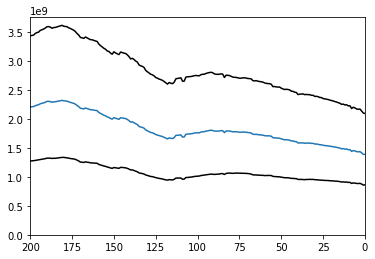

In [17]:
#carbon
plt.plot(carbon_mass_POSR[:,0], color='k')
plt.plot(carbon_mass_POSR[:,1])
plt.plot(carbon_mass_POSR[:,2], color='k')
plt.ylim(0)
plt.xlim(200,0)

(200, 0)

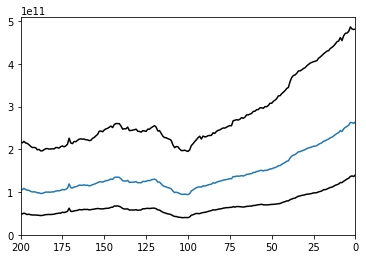

In [16]:
#serps
plt.plot(serps_mass_POSR[:,0], color='k')
plt.plot(serps_mass_POSR[:,1])
plt.plot(serps_mass_POSR[:,2], color='k')
plt.ylim(0)
plt.xlim(200,0)